<a href="https://colab.research.google.com/github/LeoGaunt/csc2034_DataScience_WineQuality/blob/main/Wine_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Machine Learning Model to predict the quality of wine


This is the accompanying notebook for *Predicting Vihno Verde Wine Quality Using Machine Learning on Physiochemical Attributes* by Leo Gaunt. The Project Report can be found [here](https://github.com/LeoGaunt/csc2034_DataScience_WineQuality/blob/04c384c4cf80be6ba593efbe13633e7c4cff80dd/Project%20Report.pdf)

To begin with clone the repository and change the directory

In [1]:
!git clone https://github.com/LeoGaunt/csc2034_DataScience_WineQuality.git

Cloning into 'csc2034_DataScience_WineQuality'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 34 (delta 11), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 1.19 MiB | 9.36 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [2]:
import os
os.chdir("csc2034_DataScience_WineQuality/data")

## Exploring the 2 Datasets

Now we have imported the datasets into collab, we can now explore the datasets and visualise them to help our understanding.

We will first look at how many wines are of each quality.

We start this process by loading all the data in from the csv using the `pandas` module

In [3]:
import pandas as pd

# Load the Data
red_wine = pd.read_csv("winequality-red.csv", delimiter=";")
white_wine = pd.read_csv("winequality-white.csv", delimiter=";")

### Data Validation

Now that the data has been imported, the data can be validated. We will check that:

*   No values are missing
*   Values are numeric



In [4]:
# Check for missing values (Outputs True if correct)
print("Red Wine Complete Dataset: ", not red_wine.isnull().values.any())
print("White Wine Complete Dataset: ", not white_wine.isnull().values.any())

# Check all values are numeric (Outputs True if correct)
print("Red Wine All Numeric: ", red_wine.select_dtypes(exclude=['number']).empty)
print("White Wine All Numeric: ", white_wine.select_dtypes(exclude=['number']).empty)

Red Wine Complete Dataset:  True
White Wine Complete Dataset:  True
Red Wine All Numeric:  True
White Wine All Numeric:  True


### Data Exploration

Throughout this investigaiton we may also want to refer to both datasets as a whole, instead of seperately as red and white wine.

In [5]:
wine_all = pd.concat([red_wine, white_wine], ignore_index=True)

Now that we have loaded the data we can have a look at how many wines in both red and white are of which quality

In [6]:
# Check unique quality values
print(red_wine["quality"].value_counts().sort_index())
print(white_wine["quality"].value_counts().sort_index())
print(wine_all["quality"].value_counts().sort_index())

quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64
quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: count, dtype: int64
quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64


We can now see the values of the qualities of each wine, however it would be much better if we could see this on a graph to visualise the data. We aregoing to use `matplotlib` to create a histogram and box plot for this data

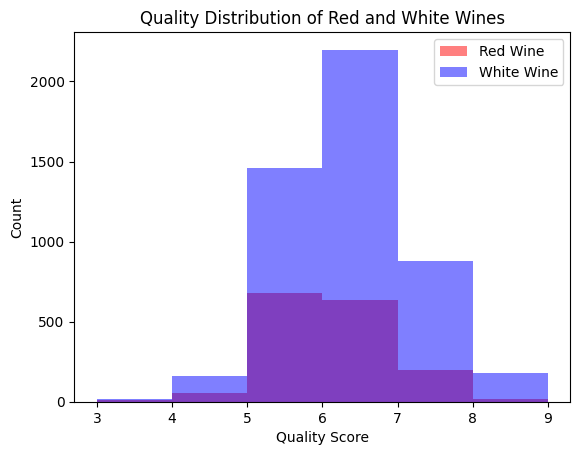

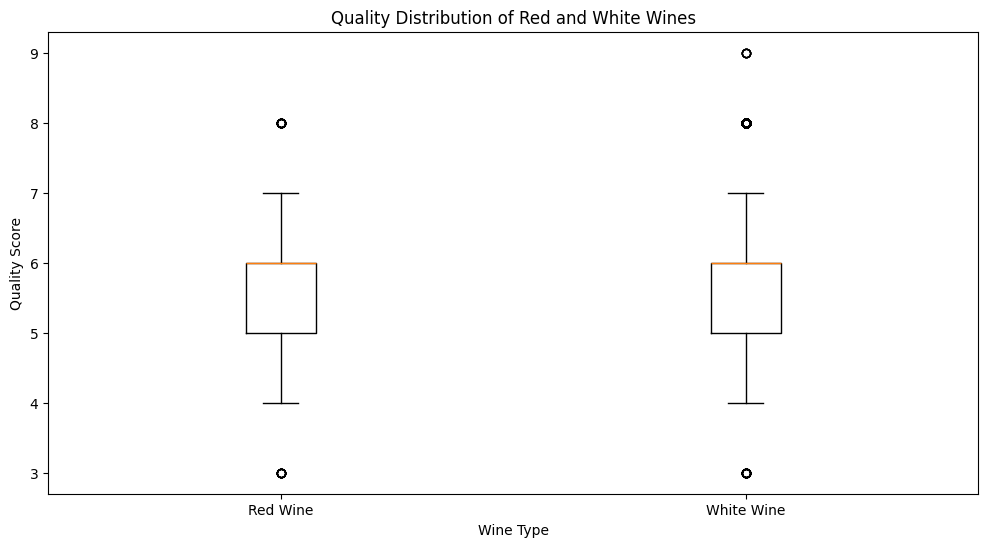

In [7]:
import matplotlib.pyplot as plt

# Plot the distributions

plt.hist(red_wine["quality"], alpha=0.5, label="Red Wine", color="red", bins=range(3, 10))
plt.hist(white_wine["quality"], alpha=0.5, label="White Wine", color="blue", bins=range(3, 10))
plt.legend(loc="upper right")
plt.xlabel("Quality Score")
plt.ylabel("Count")
plt.title("Quality Distribution of Red and White Wines")
plt.show()

plt.figure(figsize=(12,6))
plt.boxplot([red_wine["quality"], white_wine["quality"]], tick_labels=["Red Wine", "White Wine"])
plt.xlabel("Wine Type")
plt.ylabel("Quality Score")
plt.title("Quality Distribution of Red and White Wines")
plt.show()

Although these graphs were technically correct, we can see that the histogram was harder to interpret due to the difference in datapoints. Therefore we must normalise the data before interpreting, to make it easier to interpret.

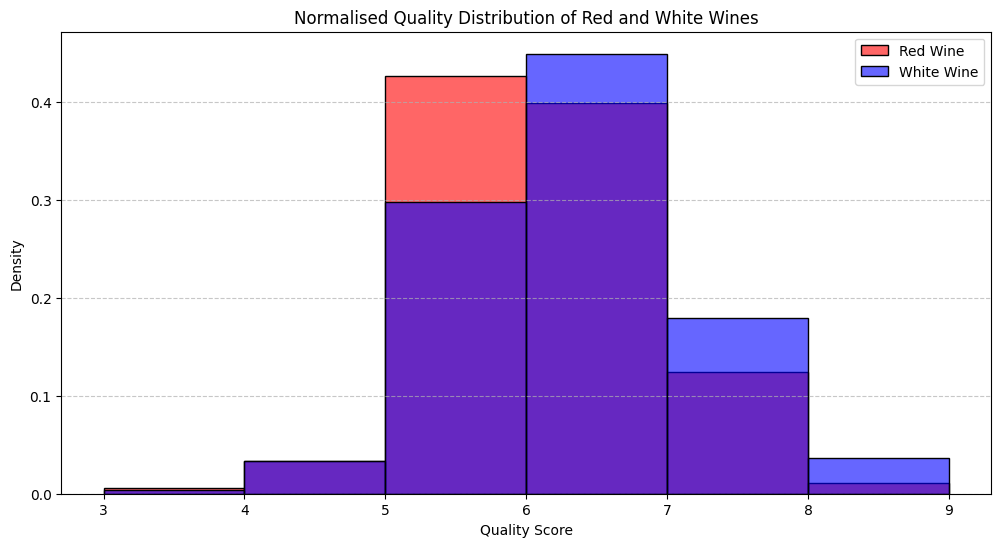

In [8]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.histplot(red_wine["quality"], bins=range(3, 10), kde=False, color="red", label="Red Wine", alpha=0.6, stat="density")
sns.histplot(white_wine["quality"], bins=range(3, 10), kde=False, color="blue", label="White Wine", alpha=0.6, stat="density")
plt.xlabel("Quality Score")
plt.ylabel("Density")
plt.title("Normalised Quality Distribution of Red and White Wines")
plt.legend()
plt.xticks(range(3, 10))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Now that the graph is normalised, it is much easier to see that white wines have a higher density of higher quality ratings compared to the red wine.

After looking at the wines separately for reds and whites, I want to now look at both datasets together to make some generalised comments

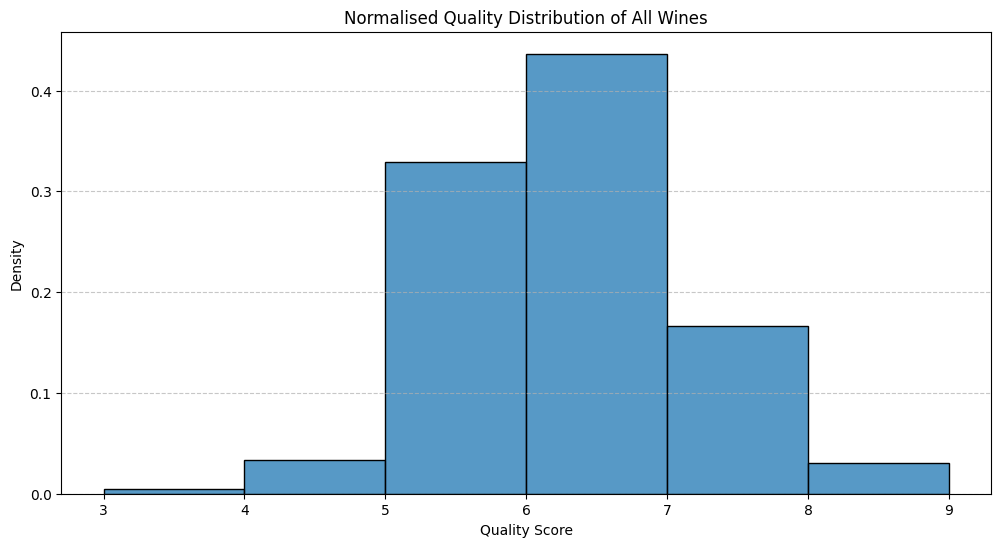

In [9]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.histplot(wine_all["quality"], bins=range(3, 10), kde=False, stat="density")
plt.xlabel("Quality Score")
plt.ylabel("Density")
plt.title("Normalised Quality Distribution of All Wines")
plt.xticks(range(3, 10))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

There isn't too much difference between this graph and both the red and white wine graph, as both types predominantly scored between 5 and 7 in quality. This indicates that independent of the wine colour, there were similar physiochemical factors influencing the wine types

### Comparing quality against alcohol content

To make comments about quality against alcohol content, it may be easier to work with categories so it is easier to compare. We can do this by discretising the alcohol content variables into low, med and high based on its distribution. This will be decided by

* `low < (avg - stddev)`
* `(avg - stddev) < med < (avg + stddev)`
* `(avg + stddev) < high`

We will create a 3-valued `alcohol_cat` variable that will be added to easach `DataFrame` to hold this information.

In [10]:
red_bins = [0,
        (red_wine["alcohol"].mean() - red_wine["alcohol"].std()),
        (red_wine["alcohol"].mean() + red_wine["alcohol"].std()),
        float('inf')]

white_bins = [0,
        (white_wine["alcohol"].mean() - white_wine["alcohol"].std()),
        (white_wine["alcohol"].mean() + white_wine["alcohol"].std()),
        float('inf')]

labels = ["low", "med", "high"]

red_wine["alcohol_cat"] = pd.cut(red_wine["alcohol"], bins=red_bins, labels=labels)
white_wine["alcohol_cat"] = pd.cut(white_wine["alcohol"], bins=white_bins, labels=labels)

Now that the wines have been sorted into discrete bins, we can update this into the `wines_all` DataFrame and then view the raw values.

In [ ]:
wine_all = pd.concat([red_wine, white_wine], ignore_index=True)

In [11]:
print(red_wine["alcohol_cat"].value_counts().sort_index())
print(white_wine["alcohol_cat"].value_counts().sort_index())

alcohol_cat
low      194
med     1125
high     280
Name: count, dtype: int64
alcohol_cat
low      845
med     3121
high     932
Name: count, dtype: int64


We can now describe the wine quality as we did earlier, but serperately for low, mid and high alcohol content. However this is now going to be done with a combination of all wines, not separate for red and white.

We will now create a boxplot to be able to explore the comparisons.

In [13]:
plt.figure(figsize=(8,6))
sns.boxplot(x="alcohol_cat", y="quality", data=wine_all, hue="alcohol_cat", palette="coolwarm")
plt.title("Wine Quality by Alcohol Content Group (All Wines)")
plt.xlabel("Alcohol Group")
plt.ylabel("Quality Score")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

ValueError: Could not interpret value `alcohol_cat` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

### Plotting the residual sugar variable and identify "sweet" and "dry" wines

Plotting a histogram will help us get a visual idea of how the wines' residual sugar values are distributed

In [ ]:
plt.hist(wine_all["residual sugar"], alpha=0.5, bins=range(0, 25))
plt.xlabel("Residual Sugar")
plt.ylabel("Count")
plt.title("Residual Sugar Distribution of Wines")
plt.show()

We can now split the wines at the threshold which I decided to be the median.

In [ ]:
threshold = wine_all["residual sugar"].median()
print("Threshold for 'isSweet':", threshold)
wine_all["isSweet"] = wine_all["residual sugar"] > threshold

### Distribution Analysis of Quality vs isSweet

To view the distribution of the quality scores between dry and sweet wines we can use a boxplot to get a side-by-side comparison

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x="isSweet", y="quality", data=wine_all, hue="isSweet", palette=["#66c2a5", "#fc8d62"])
plt.xticks([0, 1], ["Dry", "Sweet"])
plt.xlabel("Sweetness")
plt.ylabel("Quality Score")
plt.title("Wine Quality Distribution: Dry vs Sweet")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

## Determining which subset of variables is most useful for learning

For this part, we need to calculate the correlations between each pair the variables. we do this by creating a Correlation Matrix. We will do this by using the `seaborn` package and displaying as a heatmap

In [ ]:
corr_matrix = wine_all.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of All Wine Features")
plt.show()

I have chosen to use the pearson ranking method so we can look at feature-feature relationships to anaylse redundancy as well as feature-quality

For the models we are going to use the 5 most correlated features with quality. These were

| Feature | Correllation |
| --- | ---|
| alcohol | +0.44 |
| sulphates | +0.25 |
| volitile acidity | -0.27 |
| density | -0.26 |
| chlorides | -0.20 |

## Experiment with machine learning approaches

We will begin by creating binary classifiers then move onto continuous regressors

### Binary Classification

We will start by creating a new column on the `DataFrame` that allows us to determine between 1 for high quality and 0 for low quality. The initial threshold will be 6.

In [ ]:
wine_all["quality_label"] = (wine_all["quality"] >= 6).astype(int)

We can now define X and y with the selected features

In [ ]:
features = ["alcohol", "sulphates", "volatile acidity", "density", "chlorides"]

X = wine_all[features]
y_binary = wine_all["quality_label"]

We can now split and scale the data.

First we need to import the needed packages

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

And now split the data into the test and train counterparts, and scale the data

In [ ]:
# 80% train, 20% test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# Set up scaler
scaler = StandardScaler()

# Fit on training data only
X_train_scaled = scaler.fit_transform(X_train_clf)

# Apply same transformation to test data
X_test_scaled = scaler.transform(X_test_clf)

### Logistic Regression

We will now import the Linear Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

And we can now initialise, train, and test it

In [ ]:
# initialise
log_reg = LogisticRegression(max_iter=1000, random_state=42)
# train
log_reg.fit(X_train_scaled, y_train_clf)
# predict
y_pred = log_reg.predict(X_test_scaled)

Later on, we will implement k-fold cross-validation but for now its a good idea to test the model to see how its predictions have worked out.

We can do this by using the submodule `sklearn.metrics`

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

The performance data for the Logistic Regression Model is as follows. This data will be analysed later in k-fold cross-validation.

In [ ]:
print("Accuracy:", accuracy_score(y_test_clf, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_clf, y_pred))
print("\nClassification Report:\n", classification_report(y_test_clf, y_pred))

### Random Forest Classifier

We will now import the Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Like we did for Logistic Regression, we can now initialise, train and predict from the model

In [ ]:
# initlialise
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# train
rf.fit(X_train_scaled, y_train_clf)
# predict
y_pred_rf = rf.predict(X_test_scaled)

Evaluation to check it is working:

In [ ]:
print("Accuracy:", accuracy_score(y_test_clf, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_clf, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test_clf, y_pred_rf))

### Continuous Regression

Now moving onto continuouts regression, we need to redefine y fore regression as it is now predicting a number, not a binary value.

In [ ]:
y_reg = wine_all["quality"]

And just like we did for classification, we will split and scale the data in the same way

In [ ]:
# 80% train, 20% test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

# Set up scaler
scaler = StandardScaler()

# Fit on training data only
X_train_scaled = scaler.fit_transform(X_train_reg)

# Apply same transformation to test data
X_test_scaled = scaler.transform(X_test_reg)

### Linear Regression

We can now import the Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression

And now we can once again initialise, train and predict from this model

In [ ]:
# initialise
lin_reg = LinearRegression()
# train
lin_reg.fit(X_train_scaled, y_train_reg)
# predict
y_pred = lin_reg.predict(X_test_scaled)

Instead of accuracy, regression models' performance are evaluated using MSE and RMSE. We will need to import 2 packages to help us with this

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

Now we can calculate the MSE and RMSE to check how this model has performed

In [ ]:
mse = mean_squared_error(y_test_reg, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))

print(f"Linear Regression MSE: {mse:.2f}")
print(f"Linear Regression RMSE: {rmse:.2f}")

### Random Forest Regressor

We can now import our final model, the Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

We can then initalise it, and use our data to train and predict from it

In [ ]:
# initialise
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
# train
rf_reg.fit(X_train_scaled, y_train_reg)
# predict
y_pred_rf = rf_reg.predict(X_test_scaled)

Then evaluate it's performance the same way we did Linear Regression

In [ ]:
mse_rf = mean_squared_error(y_test_reg, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_rf))

print(f"Random Forest MSE: {mse_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")

## Model Evaluation using k-fold cross-validation

We will now evaluate our models using k-fold cross-validation. Why? Because it uses all our data for both training and testing and reduces the chance that our evaluation it biased by a lucky/unlucky split

To start with we need to import the module required

In [ ]:
from sklearn.model_selection import cross_val_score

### Binary Classification

I have chosen that our classification results will be scored by

* F1 Score
* Accuracy
* AUC Score

Evaluating over multiple value types allows us to be able to draw better conclusions about its performance. I have chosen to calculate the standard deviation of the F1 Score to determine whether our data has been subject to overfitting as well.

### Logistic Regression

In [ ]:
f1_scores_log = cross_val_score(log_reg, X_train_scaled, y_train_clf, cv=5, scoring='f1')
accuracy_scores_log = cross_val_score(log_reg, X_train_scaled, y_train_clf, cv=5, scoring='accuracy')
auc_scores = cross_val_score(log_reg, X_train_scaled, y_train_clf, cv=5, scoring='roc_auc')

print("Logistic Regression Cross-Validation Results:")
print(f"Mean F1 Score: {f1_scores_log.mean():.3f}")
print(f"Std Dev F1 Score: {f1_scores_log.std():.3f}")
print(f"Mean Accuracy: {accuracy_scores_log.mean():.3f}")
print(f"Mean AUC Score: {auc_scores.mean():.3f}")

### Random Forest Classifier

In [ ]:
f1_scores = cross_val_score(rf, X_train_scaled, y_train_clf, cv=5, scoring='f1')
accuracy_scores = cross_val_score(rf, X_train_scaled, y_train_clf, cv=5, scoring='accuracy')
auc_scores = cross_val_score(rf, X_train_scaled, y_train_clf, cv=5, scoring='roc_auc')

print("Random Forest Classifier Cross-Validation Results:")
print(f"Mean F1 Score: {f1_scores.mean():.3f}")
print(f"Std Dev F1 Score: {f1_scores_log.std():.3f}")
print(f"Mean Accuracy: {accuracy_scores.mean():.3f}")
print(f"Mean AUC Score: {auc_scores.mean():.3f}")

### Continuous Regression

For regression, I have chosen to evaluate the performance over the models by calculating:

* MSE (Mean Squared Error)
* RMSE (Root Mean Squared Error)

`sklearn` has a built in scorer for MSE but we need to create one for RMSE

For regression I have decided to also calculate the standard deviation of the RMSE scores so that we can look for signs of overfitting

In [ ]:
from sklearn.metrics import make_scorer, mean_squared_error

# Custom scorer for RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
# MSE scorer
mse_scorer = 'neg_mean_squared_error'

### Linear Regression

In [ ]:
rmse_scores_lin = cross_val_score(lin_reg, X_train_scaled, y_train_reg, cv=5, scoring=rmse_scorer)
mse_scores_lin = cross_val_score(lin_reg, X_train_scaled, y_train_reg, cv=5, scoring=mse_scorer)

print("Linear Regression Cross-Validation Results:")
print(f"Mean RMSE: {-rmse_scores_lin.mean():.3f}")
print(f"Mean MSE: {-mse_scores_lin.mean():.3f}")
print(f"Std Dev RMSE: {rmse_scores_lin.std():.3f}")

### Random Forest Regressor

In [ ]:
rmse_scores = cross_val_score(rf_reg, X_train_scaled, y_train_reg, cv=5, scoring=rmse_scorer)
mse_scores_lin = cross_val_score(rf_reg, X_train_scaled, y_train_reg, cv=5, scoring=mse_scorer)

print("Random Forest Regressor Cross-Validation Results:")
print(f"Mean RMSE: {-rmse_scores.mean():.3f}")
print(f"Mean MSE: {-mse_scores_lin.mean():.3f}")
print(f"Std Dev RMSE: {rmse_scores_lin.std():.3f}")